# Lab01 - Classification with Linear Models

# Outline
- [ 1 - Objective ](#1)
- [ 2 - Packages ](#2)
- [ 3 - Data Loading & Preprocessing ](#3)
- [ 4 - Linear Model - Logistic Regression ](#4)
- [ 5 - Support Vector Machine (SVM) ](#5)
- [ 6 - Curse of Dimensionality & Dimensionality Reduction ](#6)
- [ 7 - Model Evaluation & Comparison ](#7)

<a name="1"></a>
## 1. Objective
- Apply linear models and SVMs to classify fashion items from the Fashion-MNIST dataset.
- Explore how the curse of dimensionality affects model performance and use techniques like dimensionality reduction to mitigate it.

<a name="2"></a>
## 2. Packages
Import all the packages that we will need during this lab.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
#import tensorflow as tf
import seaborn as sns

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml

<a name="3"></a>
## 3. Data Loading, Data Exploring and Preprocessing

## Download the Fashion-MNIST dataset

In [3]:
mnist_fashion = fetch_openml('Fashion-MNIST', cache=True)
X = mnist_fashion['data']
y = mnist_fashion['target']

/home/tmhoang/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Show image

In [4]:
def show_image(x):
    image = x.to_numpy().reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

Print shape of dataset

In [5]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (70000, 784)
Shape of y: (70000,)


Basic statistics of features

In [6]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pixel1,70000.0,0.000771,0.087339,0.0,0.0,0.0,0.0,16.0
pixel2,70000.0,0.006414,0.296605,0.0,0.0,0.0,0.0,45.0
pixel3,70000.0,0.034486,1.200882,0.0,0.0,0.0,0.0,218.0
pixel4,70000.0,0.098886,2.458872,0.0,0.0,0.0,0.0,185.0
pixel5,70000.0,0.247843,4.408110,0.0,0.0,0.0,0.0,227.0
...,...,...,...,...,...,...,...,...
pixel780,70000.0,17.968129,45.231601,0.0,0.0,0.0,0.0,255.0
pixel781,70000.0,8.524043,29.527900,0.0,0.0,0.0,0.0,255.0
pixel782,70000.0,2.751400,17.385770,0.0,0.0,0.0,0.0,255.0
pixel783,70000.0,0.836529,9.258426,0.0,0.0,0.0,0.0,255.0


In [7]:
y.describe()

count     70000
unique       10
top           0
freq       7000
Name: class, dtype: object

### __Exploratory Data Analysis__

#### __Frequency of each classes in dataset__

<Axes: xlabel='count', ylabel='class'>

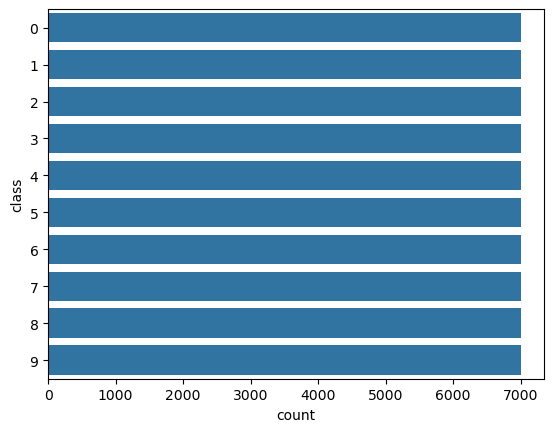

In [8]:
sns.countplot(y)

All classes share a frequency of 7000 samples. This shows that there is no imbalance phenomenon.

#### __Cosine similiarity Distribution of each Class__
Cosine similiarity shows Distribution how similar individual samples in a specific class are to the "mean vector" (average representation) of that class. This plot is a key to understand patterns within classes and identifying potential outliers or variations.

Mean:  0.904, Std:  0.079


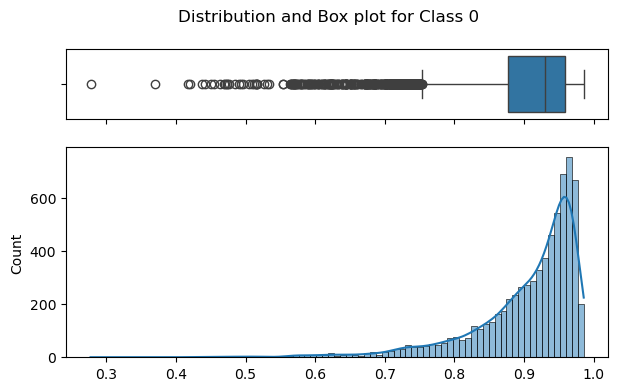

Mean:  0.910, Std:  0.064


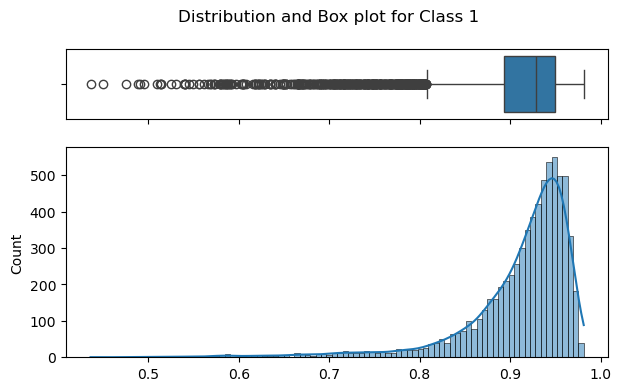

Mean:  0.906, Std:  0.064


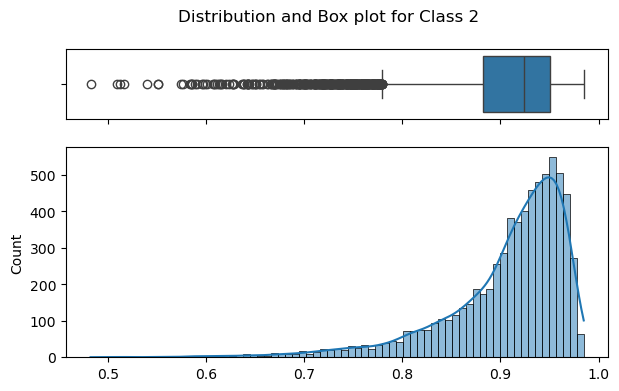

Mean:  0.890, Std:  0.062


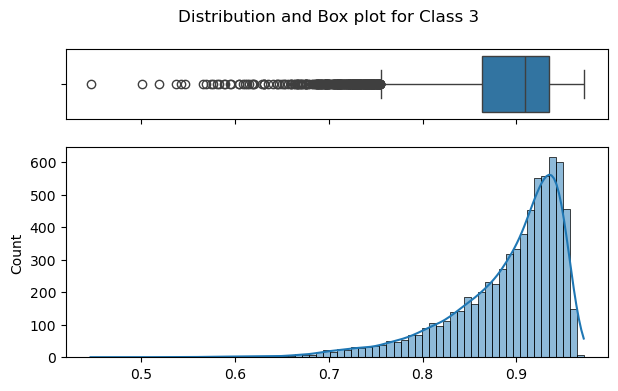

Mean:  0.916, Std:  0.057


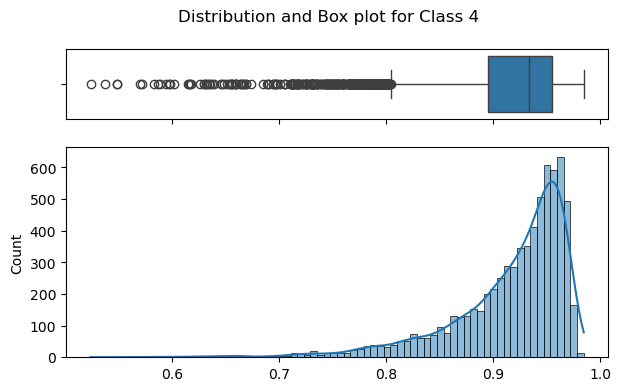

Mean:  0.658, Std:  0.109


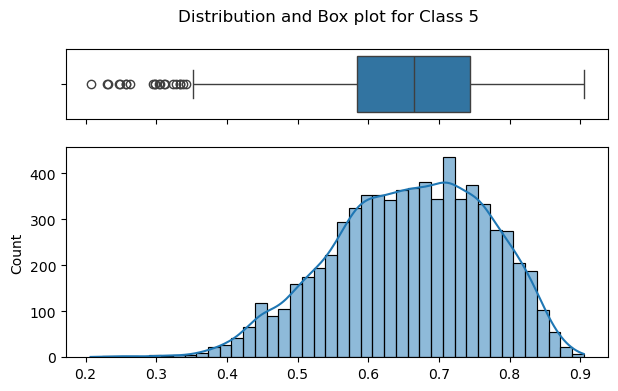

Mean:  0.884, Std:  0.070


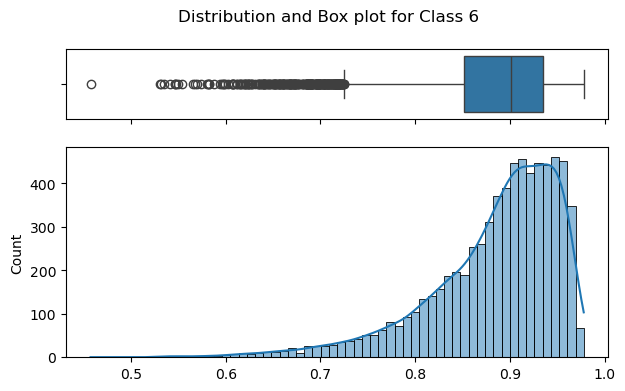

Mean:  0.865, Std:  0.063


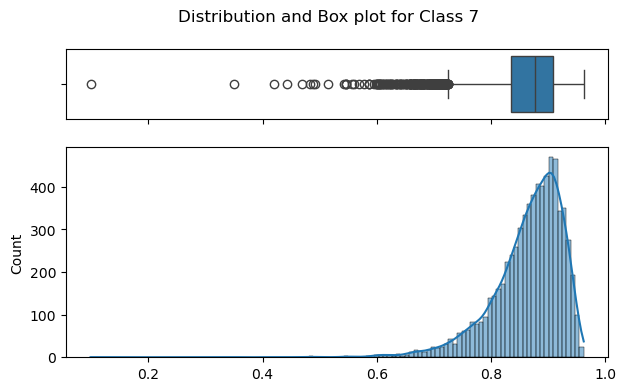

Mean:  0.841, Std:  0.079


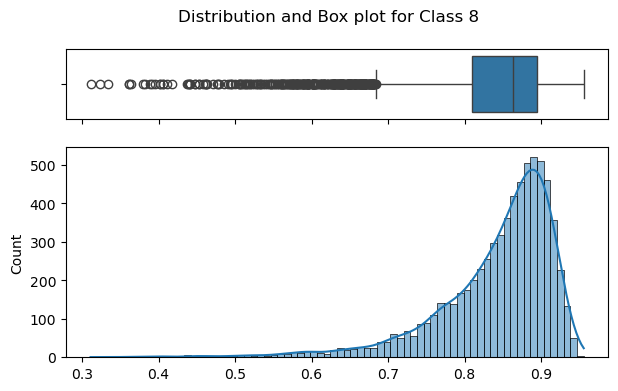

Mean:  0.886, Std:  0.053


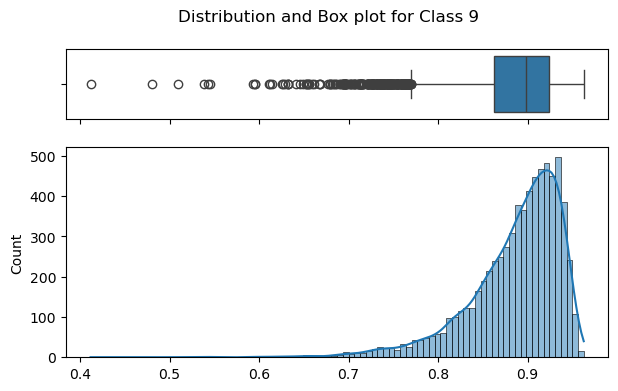

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

X_train_flattened = X.values.reshape(X.shape[0], -1)

def cosine_similarity_distribution(X, y, class_label):
    # Extract data for the specified class
    class_data = X[y == class_label]

    # Compute the mean vector for the class
    mean_vector = class_data.mean(axis=0).reshape(1, -1)

    # Calculate cosine similarities
    similarities = cosine_similarity(class_data, mean_vector).flatten()

    return similarities

def plot_distribution_and_box(x, plot_name, figsize=(7, 4)):

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [1, 3]})
    sns.boxplot(x, ax=axes[0], orient="h")
    sns.histplot(x, kde=True, ax=axes[1])

    fig.suptitle(f"Distribution and Box plot for {plot_name}")
    # Show the plot
    plt.show()

for class_label in np.unique(y):
    simlilarity = cosine_similarity_distribution(X_train_flattened, y, class_label)
    print(f'Mean: {np.mean(simlilarity): .3f}, Std: {np.std(simlilarity): .3f}')
    plot_distribution_and_box(simlilarity, f'Class {class_label}')


- Most of the distributions are left-skewed, with a mean greater than 0.85 and a standard deviation exceeding 0.1. Additionally, many samples lie outside the interquartile range, indicating the presence of potential outliers within these distributions.
- An exception is the distribution for `class 5`, which has a distinctive U-shaped (or bell-like) curve. Its mean is 0.658, with a standard deviation of 0.109. Futhermore, this plot has noticeably fewer potential outliers compared to the others.

#### __Null checking__

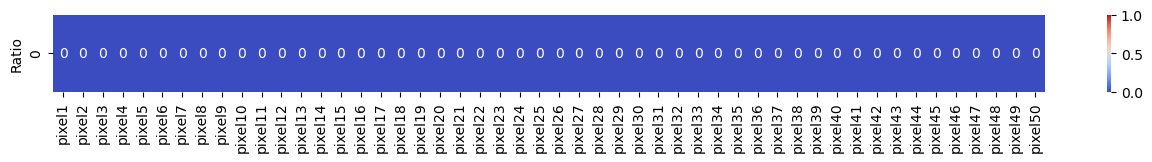

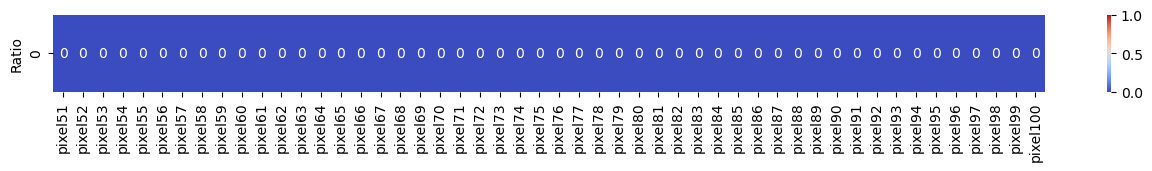

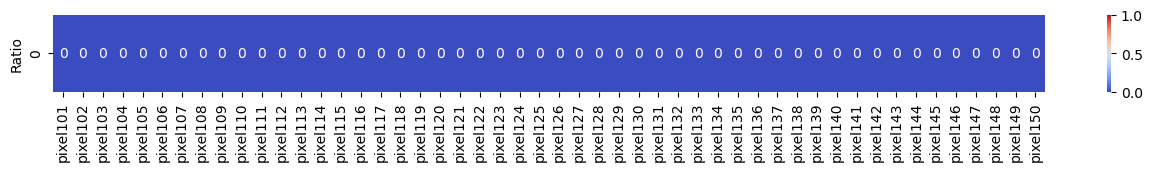

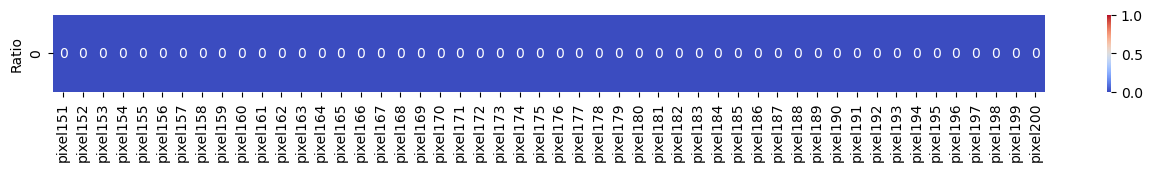

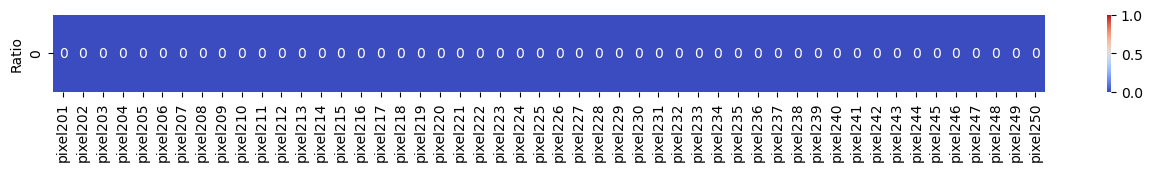

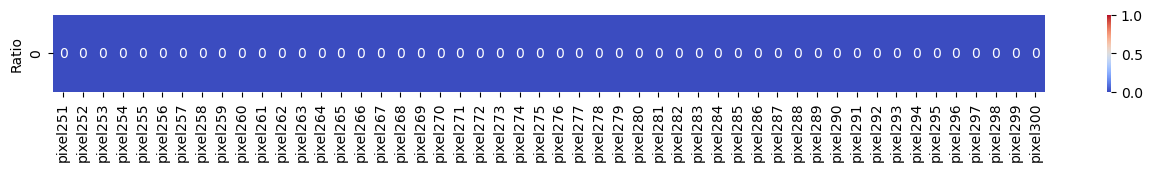

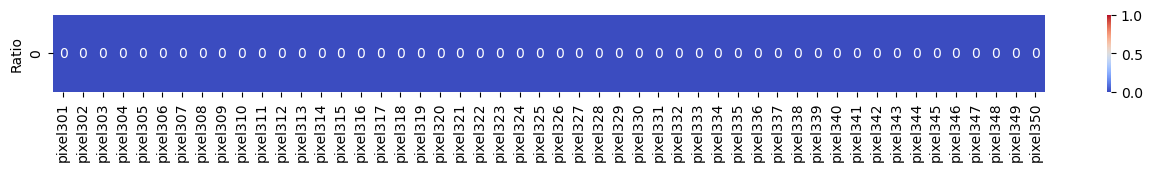

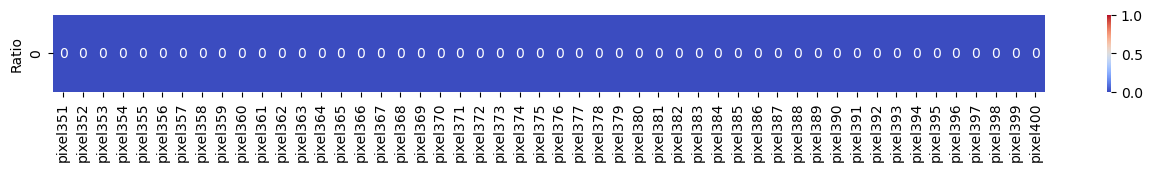

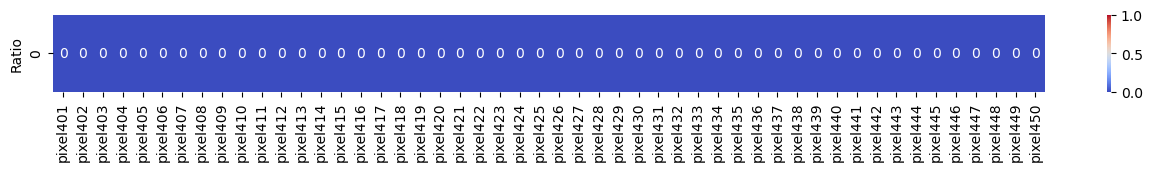

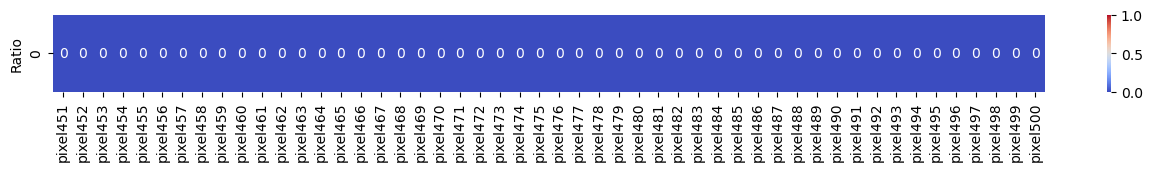

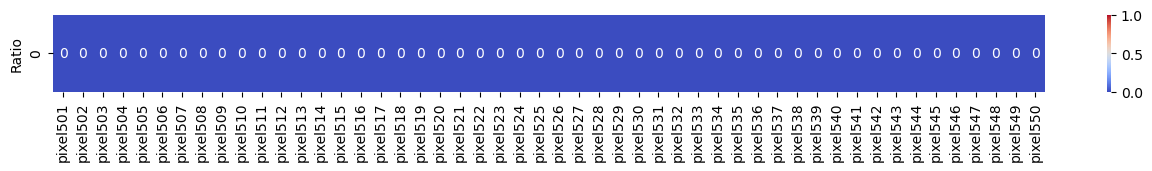

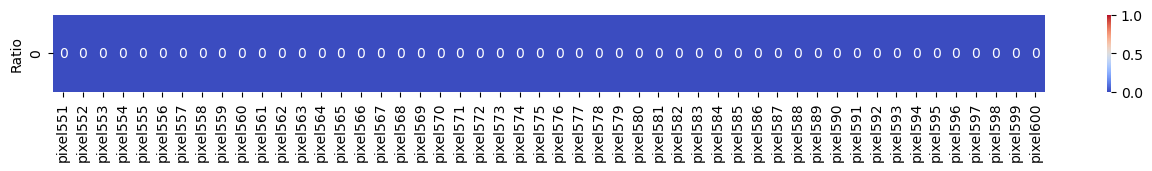

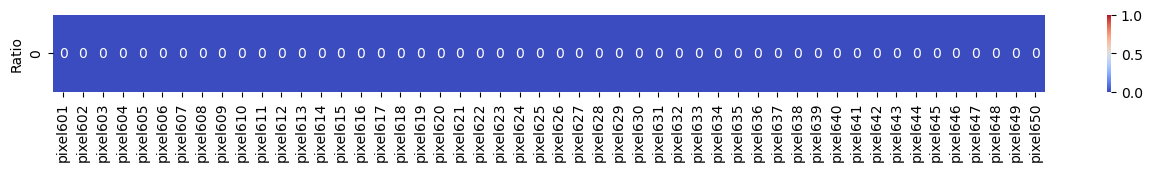

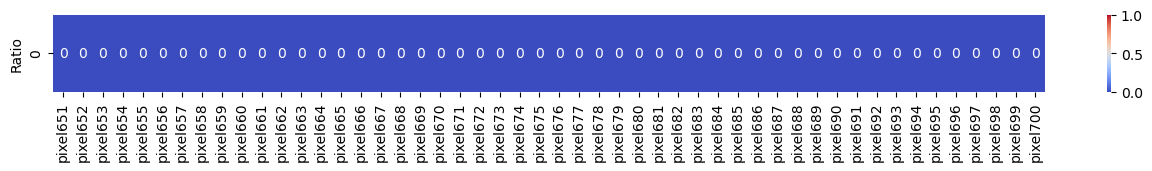

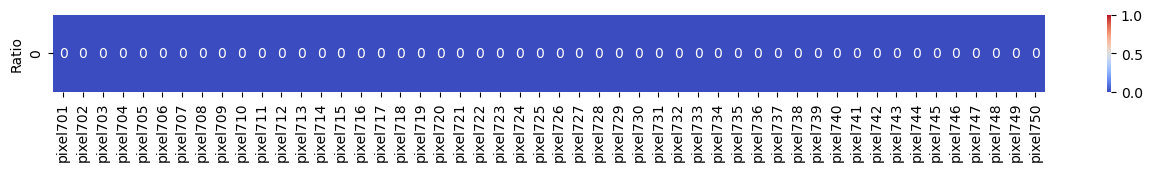

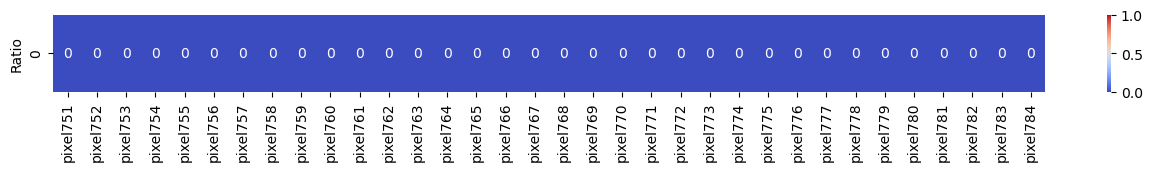

In [10]:
null_ratio = pd.DataFrame(X.isnull().sum() / X.shape[0])
batch_size = 50
for i in range(0, null_ratio.shape[0], batch_size):
    plt.figure(figsize=(16, 1))
    sns.heatmap(null_ratio[i: i+ batch_size].T, cbar=True, cmap='coolwarm', vmin=0, vmax=1, annot=True)
    plt.ylabel('Ratio')
    plt.show()

There is no null value in 784 features

### __Preprocessing__

__Spliting set__

In [11]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X train shape: {X_train.shape} - X test shape: {X_test.shape}")
print(f"y train shape: {y_train.shape} - y test shape: {y_test.shape}")

X train shape: (56000, 784) - X test shape: (14000, 784)
y train shape: (56000,) - y test shape: (14000,)


__Encoding y__

Using `LabelEncoder` from `sklearn.preprocessing` as an encoder

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print(f'Encoding map: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}')

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Encoding map: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


__Scaling X__

For easier comparation with lower dimensionaltity dataset in later section, `StandardScaler` will be applied.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler_list = []
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

for column in X_train.columns:
    scaler = StandardScaler()
    scaler.fit(X_train[column].values.reshape(-1, 1))
    X_train_scaled[column] = scaler.transform(X_train[column].values.reshape(-1, 1))
    X_test_scaled[column] = scaler.transform(X_test[column].values.reshape(-1, 1)) # scaled base on mean and std of X train

    scaler_list.append(scaler) # Store the scaler for later usings

print(f"First sample of X_train before scaling: {X_train.iloc[0].values}")
print(f"First sample of X_train after scaling: {X_train_scaled.iloc[0].values}")

First sample of X_train before scaling: [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  52. 107.   0.  81. 133.  66.  59.  62.  51.  51.  66.  75.  78.  66.
  60.  58.  62.  66.  66.  66.  73.  

<a name="4"></a>
## 4. Logistic Regression for multi-classes

### Evaluation setup
Because we will need to evaluate our models frequently so we need some evaluation functions to save our time and make our lab look more precise.

In [14]:
import time
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Plotting confusion matrix function
def plot_confusion_matrix(y_test, y_pred):
    cfs_matrix = confusion_matrix(y_test, y_pred)
    # calculate percentage
    cfs_matrix = cfs_matrix / cfs_matrix.sum(axis=1)
    sns.set(style="whitegrid")
    sns.heatmap(cfs_matrix, annot=True, fmt=".2f", vmin=0, vmax=1, cmap='coolwarm')

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")

    plt.show()

# Evaluate function, include compute training and predicting time
def train_and_validate_model(model, X_train, y_train, X_test, y_test):
    print("Training")
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_pred = model.predict(X_train)
    training_time = end_time - start_time
    print(f">> Train time\t\t{training_time}")
    print(f">> Accuracy\t\t{accuracy_score(y_train, train_pred)}")

    print("\nTesting")
    start_time = time.time()
    test_pred = model.predict(X_test)
    end_time = time.time()
    testing_time = end_time - start_time
    accuracy, f1, precision, recall = accuracy_score(y_test, test_pred), f1_score(y_test, test_pred, average='macro'), precision_score(y_test, test_pred, average='macro'), recall_score(y_test, test_pred, average='macro')

    print(f">> Predict time\t\t{testing_time}")
    print(f">> Accuracy\t\t{accuracy}")
    print(f">> F1 score\t\t{f1}")
    print(f">> Precision score\t{precision}")
    print(f">> Recall score\t\t{recall}")

    plot_confusion_matrix(y_test, test_pred)

    return [training_time, testing_time, accuracy, f1, precision, recall]

### Training and validiation

Training


/home/tmhoang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


>> Train time		6.266871690750122
>> Accuracy		0.8762857142857143

Testing
>> Predict time		0.058548927307128906
>> Accuracy		0.8517857142857143
>> F1 score		0.8506612091839256
>> Precision score	0.8501822558205718
>> Recall score		0.8517360989628052


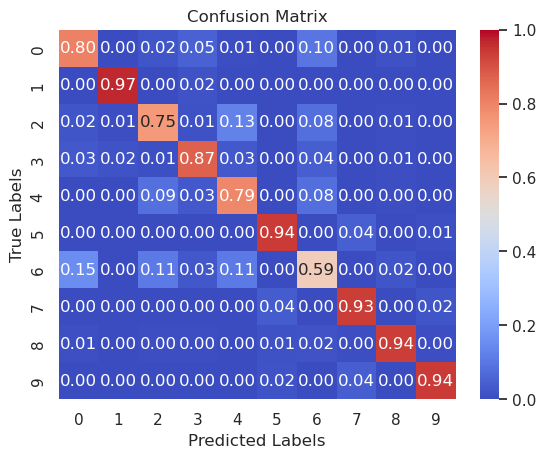

In [38]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()

lr_evaluation = train_and_validate_model(lr_model, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded)

The accuracy of the training set and the test set differ very little, so there is no overfitting. And because the accuracy is quite high, underfitting also does not occur.

Most classes have their high accuracy which is over than 0.7. A sole exception is `Class 6` which accuracy is 0.59/ `Class 6` is confused as `Class 0` in 15% of cases, `Class 2` and `Class 4` in 11% of cases.

# <a name="5"></a>
## 5. Support Vector Machine (SVM)
Because this is a problem where the number of labels of each class is the same (not being imbalanced) and the amount of data is large, we will use the OVR (One-vs-Rest) method (default in sklearn).

We will use 2 types of kernel:
- Linear kernel:
$$
K(x,x') = x^Tx'
$$

- RBF (Radial Basis Fun) kernel:
$$
K(x,x') = e^{-y\| x - x' \|^2}
$$

### Linear kernel

Training
>> Train time		572.3725335597992
>> Accuracy		0.9126607142857143

Testing
>> Predict time		65.00660514831543
>> Accuracy		0.8460714285714286
>> F1 score		0.845312499097807
>> Precision score	0.8458306676874529
>> Recall score		0.8459402169675947


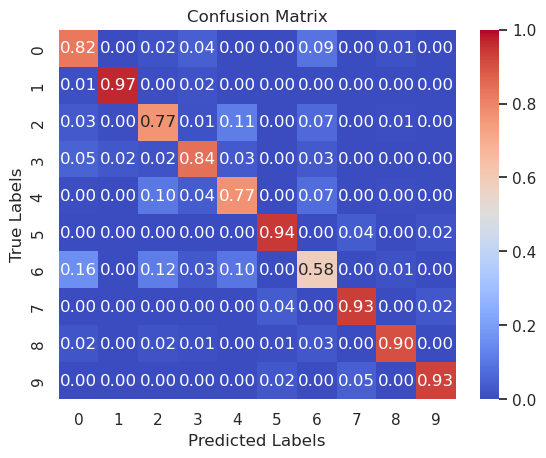

In [18]:
# SVM linear kernel from sklearn
svm_linear = SVC(kernel='linear')

svm_linear_evaluation = train_and_validate_model(svm_linear, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded)

The first observation is that SVM takes a significantly longer time to run compared to Logistic Regression. Additionally, SVM seems to have a slight tendency to overfit, performing better on the training set than Logistic Regression but not performing as well as this model on unseen data.

### RBF kernel

Training
>> Train time		232.52458238601685
>> Accuracy		0.9220892857142857

Testing
>> Predict time		128.97647404670715
>> Accuracy		0.8905
>> F1 score		0.8895734796882951
>> Precision score	0.8893322333607694
>> Recall score		0.8906015051535887


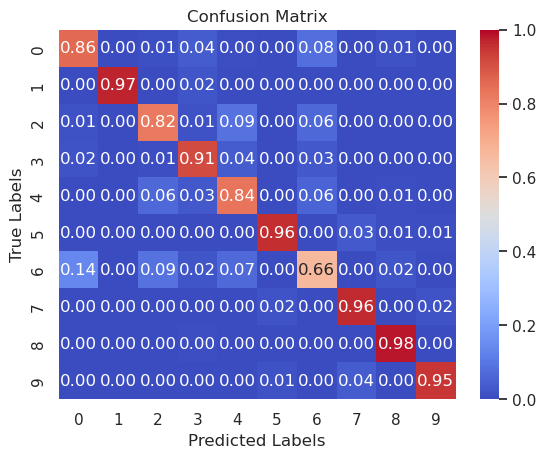

In [19]:
# SVM classfication from sklearn
svm_rbf = SVC(kernel='rbf')

svm_rbf_evaluation = train_and_validate_model(svm_rbf, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded)

Since our data is balanced across classes (with 10 classes, 7000 samples per class), we will use **accuracy** as the main metric to evaluate the models' performance.

With the RBF kernel, we observe that SVM performs significantly better on unseen data:
- Our lowest accuracy class, `Class 6`, improved from __0.56__ in Logistic Regression and __0.58__ with the linear kernel to __0.66__. However, we still see a high level of misclassification of samples in `Class 6` as `Class 0`, which hasn’t reduced much (remaining at __0.14%__, only a __0.01%__ improvement compared to Logistic Regression).
- Almost all classes show an increase in accuracy when transitioning from Logistic Regression or SVM with the linear kernel to SVM with the RBF kernel, except for `Class 1`. This class remained unchanged across all three models, maintaining a high accuracy of __0.97__. Furthermore, with the RBF kernel, `Class 1` is rarely confused when predicting samples from other classes, indicating that `Class 1` still benefits in performance compared to the previous two models.

### Analyze and compare computation time for training and evaluation
Firstly, we will visualize the time to train and evaluate.

<Axes: >

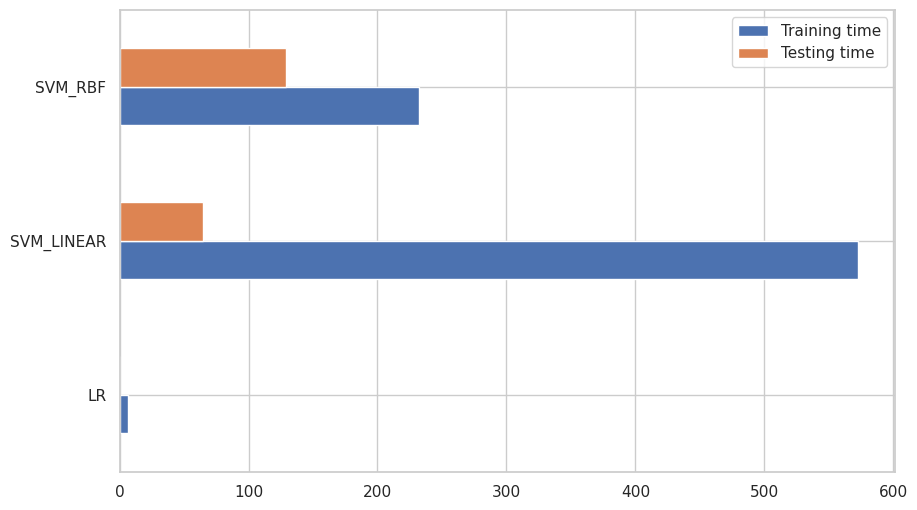

In [39]:
eval_df = pd.DataFrame({
    'LR': lr_evaluation,
    'SVM_LINEAR': svm_linear_evaluation,
    'SVM_RBF': svm_rbf_evaluation
}, index=['Training time', 'Testing time', 'Accuracy', 'F1', 'Precision', 'Recall']).T

eval_df_time = eval_df[['Training time', 'Testing time']]
eval_df_time.plot(kind='barh', figsize=(10, 6))

- With Logistic Regression, this is a linear model, so the running time for both training and testing is very fast, almost negligible.

- With SVM, we observe that the Linear kernel has a significantly longer training time but faster prediction time than the RBF kernel:
    ##### Training time:
    - Because our data has many features, using the Linear kernel requires calculations based on the original data features, which takes a lot of time.
    - With the RBF kernel, we do not need to compute each feature individually but rely on the distance matrix, so the training time is faster than the prediction time.

    ##### Testing time:
    - With the Linear kernel, the prediction process is simpler because it only requires using support vectors to calculate distances in the original linear space.
    - With the RBF kernel, we need to calculate the distance between the new data point and the support vectors in the RBF space, which makes the prediction time longer.


<a name="6"></a>
## 6. Curse of Dimensionality & Dimensionality Reduction
 __In training model progress, Reducing dimensionality of DATA has both advantage and disadvantage__
  
__Advantage__
  - Reducing unimportant features of data, noise. This can prevent overfitting and improving the model
  - Reducing the running time of model: Reducing dimension mean that reducing the size of data and reducing training time.
  - Models, especially classified models, which are trained on reduced dimensionality data by LDA perform a high effeciency as core of LDA is classification.

__Disavantage__
  - Loss information
  - Easy to lose control the model effiecency




### Linear Discriminant Analysis (LDA)

In [20]:
XTrain = np.array(X_train)
YTrain = np.array(y_train)  # Class labels
XTest =np.array(X_test)
YTest =np.array(y_test)

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)


In [22]:
X_lda_test = lda.fit_transform(XTest, YTest)
X_lda_train = lda.fit_transform(XTrain, YTrain)

In [23]:
print(np.unique(YTest))

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


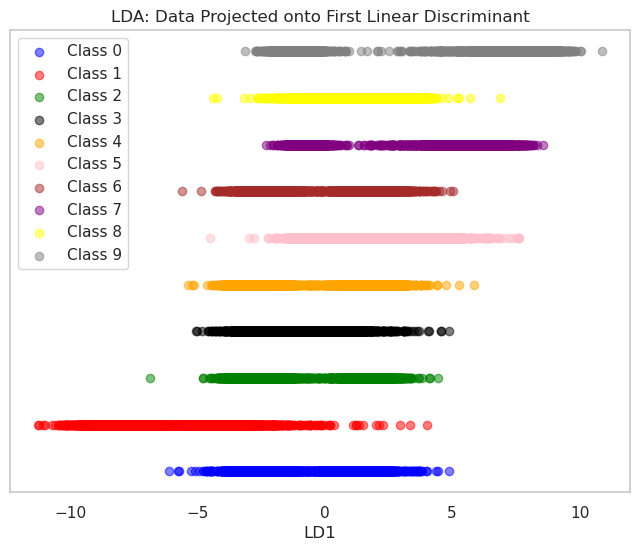

In [24]:
#visualize

plt.figure(figsize=(8, 6))
plt.scatter(X_lda_test[YTest == '0'], np.zeros_like(X_lda_test[YTest== '0']), label='Class 0', color='blue', alpha=0.5)
plt.scatter(X_lda_test[YTest == '1'], np.ones_like(X_lda_test[YTest == '1']), label='Class 1', color='red', alpha=0.5)
plt.scatter(X_lda_test[YTest == '2'], 2*np.ones_like(X_lda_test[YTest == '2']), label='Class 2', color='green', alpha=0.5)
plt.scatter(X_lda_test[YTest == '3'], 3*np.ones_like(X_lda_test[YTest == '3']), label='Class 3', color='black', alpha=0.5)
plt.scatter(X_lda_test[YTest == '4'], 4*np.ones_like(X_lda_test[YTest == '4']), label='Class 4', color='orange', alpha=0.5)
plt.scatter(X_lda_test[YTest == '5'], 5*np.ones_like(X_lda_test[YTest == '5']), label='Class 5', color='pink', alpha=0.5)
plt.scatter(X_lda_test[YTest == '6'], 6*np.ones_like(X_lda_test[YTest == '6']), label='Class 6', color='brown', alpha=0.5)
plt.scatter(X_lda_test[YTest == '7'], 7*np.ones_like(X_lda_test[YTest == '7']), label='Class 7', color='purple', alpha=0.5)
plt.scatter(X_lda_test[YTest == '8'], 8*np.ones_like(X_lda_test[YTest == '8']), label='Class 8', color='yellow', alpha=0.5)
plt.scatter(X_lda_test[YTest == '9'], 9*np.ones_like(X_lda_test[YTest == '9']), label='Class 9', color='gray', alpha=0.5)
plt.title('LDA: Data Projected onto First Linear Discriminant')
plt.xlabel('LD1')
plt.yticks([])
plt.legend()
plt.grid()
plt.show()

### PRINCIPAL COMPONENT ANALYSIS (PCA) EXPLANATION

#### Eigenvalue and Eigenvector Computation
- Solve the eigenvalue problem for the covariance matrix S :

$$
\text{Su}_1 = \lambda_1 \mathbf{u}_1
$$
#### Data Transformation :

- Using $W$, the data $x$ in the original space transforms into $y$ in reduced dimensions:

$$
y = W^T \mathbf{x}
$$

- This projection reduces the dimensionality of the data while retaining the most significant variance.

In [25]:
from sklearn.preprocessing import StandardScaler

def compute_eigenvalues_vectors(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

def pca(X, n_components):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    cov_matrix = np.cov(X_scaled, rowvar=False)

    sorted_eigenvalues, sorted_eigenvectors = compute_eigenvalues_vectors(cov_matrix)

    selected_eigenvectors = sorted_eigenvectors[:, :n_components]
    X_pca = X_scaled.dot(selected_eigenvectors)

    return X_pca, sorted_eigenvalues

In [26]:
# Implement PCA
n_components = 100  # 100 or 50
X_train_pca, eigenvalues = pca(X_train, n_components)
X_test_pca, eigenvalues = pca(X_test, n_components)

In [27]:
print(X_train_pca)

[[ 1.89612862e+00  2.23212049e+01  4.26345693e+00 ...  5.12532451e+00
   2.04455183e-01  1.85704093e+00]
 [ 1.49618703e+01 -5.13597169e+00 -1.11924054e+00 ... -3.73671774e-01
   9.87605438e-01  1.09762257e+00]
 [ 2.68815301e+01  5.18084495e+00 -6.21596098e+00 ... -3.28995881e-01
  -1.15769302e-02  7.12878458e-01]
 ...
 [-2.07486593e+01 -1.71978453e+00 -3.97976193e+00 ...  9.07164509e-01
  -1.83642358e+00 -8.92782013e-01]
 [-5.62860728e+00 -2.17929000e+00 -1.20176831e+01 ...  1.19285568e+00
   4.28086270e-01  9.88215867e-01]
 [-3.02677999e+00 -6.32262971e+00 -1.31478917e+01 ...  1.48791910e+00
   7.43989498e-01 -2.71076387e+00]]


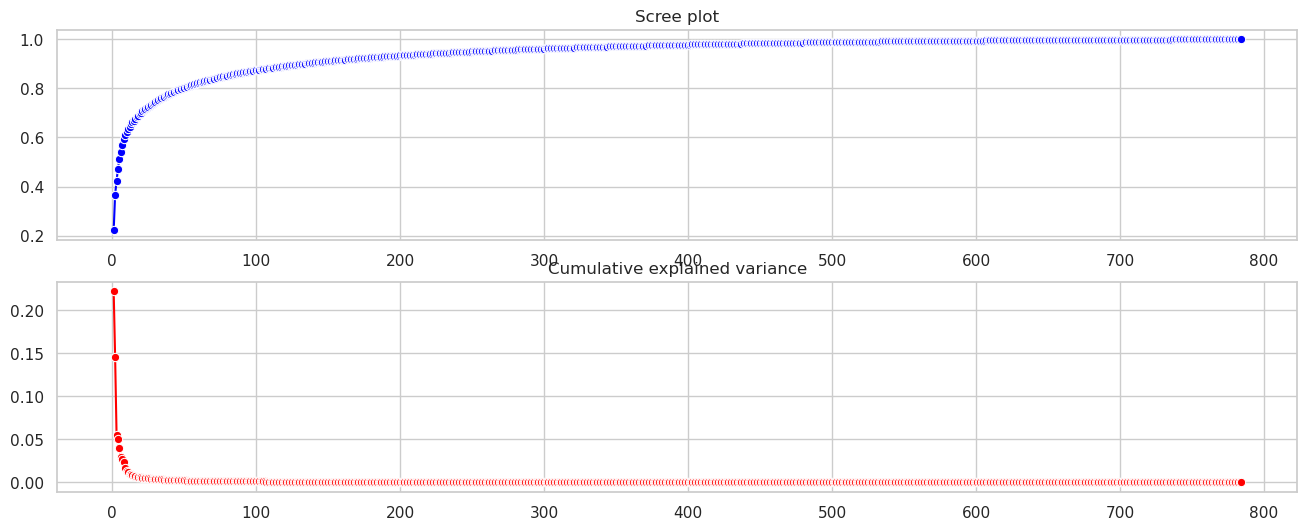

In [28]:
# Visualize
# Calculate variance ratio
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

def plot_scree_and_cumulative_variance(explained_variance_ratio):
    fig, ax = plt.subplots(2, 1, figsize=(16, 6))

    sns.lineplot(x=range(1, len(explained_variance_ratio) + 1), y=explained_variance_ratio, ax=ax[1], marker='o', color='red')
    ax[0].set_title("Scree plot")

    sns.lineplot(x=range(1, len(explained_variance_ratio) + 1), y=np.cumsum(explained_variance_ratio), ax=ax[0], marker='o', color='blue')
    ax[1].set_title("Cumulative explained variance")

    plt.show()

plot_scree_and_cumulative_variance(explained_variance_ratio)

With `n_components = 100`, the new data reduced by PCA remains about 84% information from the original data

**Retrain Logistic Regression with lower dimensionality**

In [29]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

pca = PCA(n_components=100)
lda = LDA(n_components=9)

pca.fit(X_train_scaled)
lda.fit(X_train_scaled, y_train_encoded)

X_train_pca, X_test_pca = pca.transform(X_train_scaled), pca.transform(X_test_scaled)
X_train_lda, X_test_lda = lda.transform(X_train_scaled), lda.transform(X_test_scaled)

Training


/home/tmhoang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


>> Train time		0.23085594177246094
>> Accuracy		0.8175535714285714

Testing
>> Predict time		0.0019459724426269531
>> Accuracy		0.8124285714285714
>> F1 score		0.8106952377793022
>> Precision score	0.8108896137761816
>> Recall score		0.812473484033805


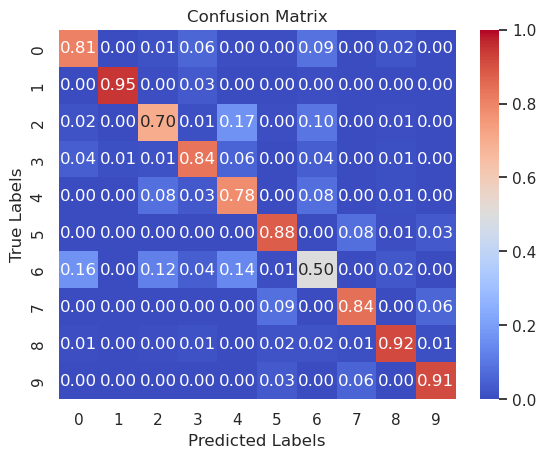

Training
>> Train time		0.11036849021911621
>> Accuracy		0.8385178571428571

Testing
>> Predict time		0.0009253025054931641
>> Accuracy		0.8271428571428572
>> F1 score		0.8264510050140155
>> Precision score	0.825955661522408
>> Recall score		0.8272096594793815


/home/tmhoang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


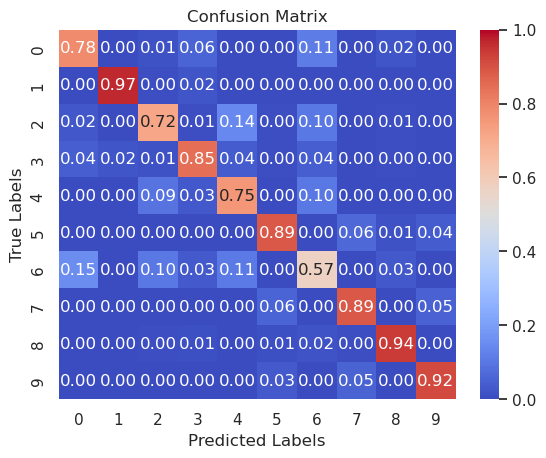

In [30]:
pca_lr_model = lda_lr_model = LogisticRegression(max_iter=10)

pca_lr_evalutation = train_and_validate_model(pca_lr_model, X_train_pca, y_train_encoded, X_test_pca, y_test_encoded)
lda_lr_evaluation = train_and_validate_model(lda_lr_model, X_train_lda, y_train_encoded, X_test_lda, y_test_encoded)

**Retrain Logistic Regression with lower dimensionality**

Linear kernel with PCA
Training
>> Train time		193.67598342895508
>> Accuracy		0.8693035714285714

Testing
>> Predict time		11.178822040557861
>> Accuracy		0.8578571428571429
>> F1 score		0.8565555298809386
>> Precision score	0.8563342929821849
>> Recall score		0.8579008890693551


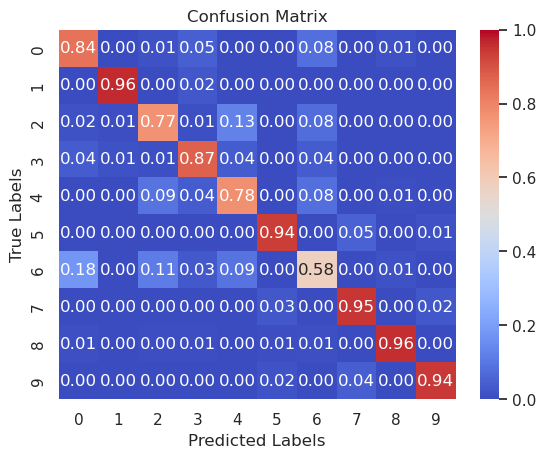

Linear kernel with LDA
Training
>> Train time		15.793198823928833
>> Accuracy		0.8432678571428571

Testing
>> Predict time		5.109235763549805
>> Accuracy		0.8327142857142857
>> F1 score		0.8316160771575036
>> Precision score	0.8314258140831132
>> Recall score		0.8329071471025028


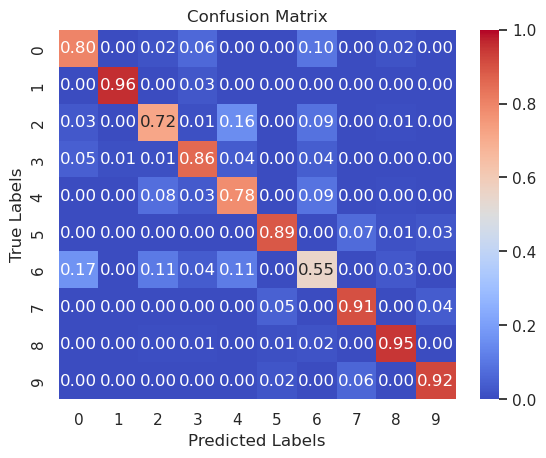

RBF kernel with PCA
Training
>> Train time		55.15462064743042
>> Accuracy		0.9020178571428571

Testing
>> Predict time		20.125060081481934
>> Accuracy		0.8847142857142857
>> F1 score		0.8838311045389938
>> Precision score	0.8837775808500288
>> Recall score		0.88483605861497


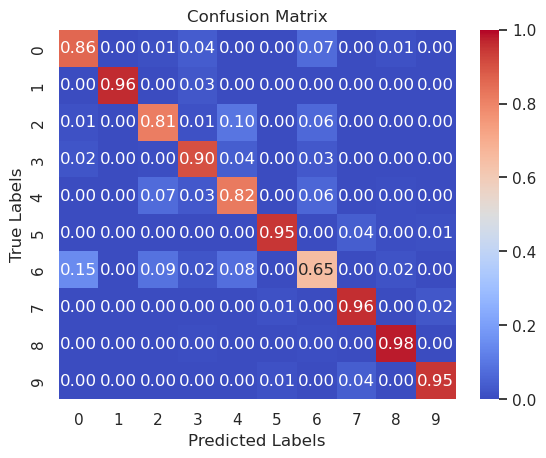

RBF kernel with LDA
Training
>> Train time		13.755596399307251
>> Accuracy		0.8518035714285714

Testing
>> Predict time		8.500992059707642
>> Accuracy		0.8415
>> F1 score		0.8396874410479128
>> Precision score	0.8402930818269343
>> Recall score		0.8417916996189094


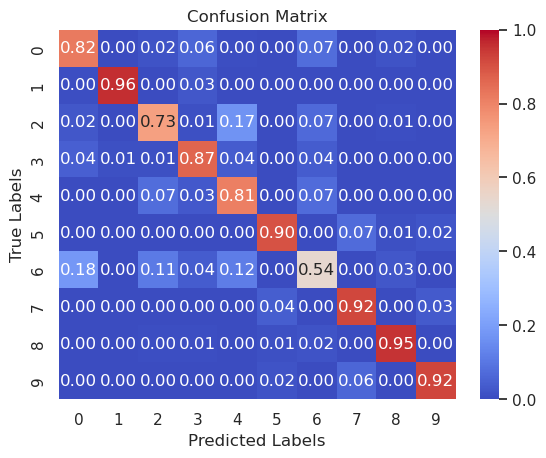

In [34]:
svm_linear_model = SVC(kernel='linear')
svm_rbf_model = SVC(kernel='rbf')

print("Linear kernel with PCA")
svm_linear_pca_evaluation = train_and_validate_model(svm_linear_model, X_train_pca, y_train_encoded, X_test_pca, y_test_encoded)

print("Linear kernel with LDA")
svm_linear_lda_evaluation = train_and_validate_model(svm_linear_model, X_train_lda, y_train_encoded, X_test_lda, y_test_encoded)

print("RBF kernel with PCA")
svm_rbf_pca_evaluation = train_and_validate_model(svm_rbf_model, X_train_pca, y_train_encoded, X_test_pca, y_test_encoded)

print("RBF kernel with LDA")
svm_rbf_lda_evaluation = train_and_validate_model(svm_rbf_model, X_train_lda, y_train_encoded, X_test_lda, y_test_encoded)

<a name="7"></a>
## 7. Model Evaluation & Comparison

### Compare the logistic regression and SVM models (linear vs. RBF kernel) on both full and reduced-dimensional

**Create plots to visualize model accuracy, confusion matrices, or performance metrics (precision, recall, F1 score) across different models and settings.**

<Axes: >

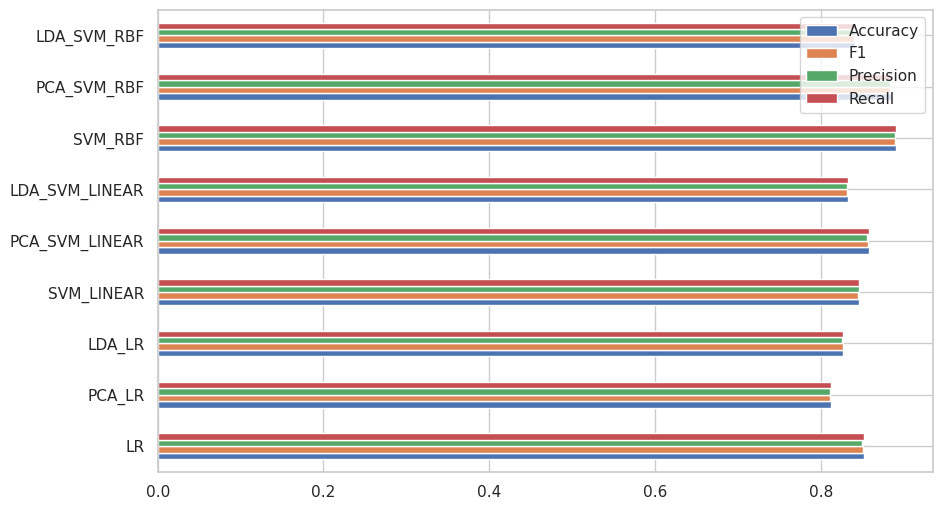

In [40]:
model_evaluation = pd.DataFrame({
    'LR': lr_evaluation,
    'PCA_LR': pca_lr_evalutation,
    'LDA_LR': lda_lr_evaluation,
    'SVM_LINEAR': svm_linear_evaluation,
    'PCA_SVM_LINEAR': svm_linear_pca_evaluation,
    'LDA_SVM_LINEAR': svm_linear_lda_evaluation,
    'SVM_RBF': svm_rbf_evaluation,
    'PCA_SVM_RBF': svm_rbf_pca_evaluation,
    'LDA_SVM_RBF': svm_rbf_lda_evaluation

}, index=['Training time', 'Testing time', 'Accuracy', 'F1', 'Precision', 'Recall']).T

model_evaluation_performance = model_evaluation[['Accuracy', 'F1', 'Precision', 'Recall']]
model_evaluation_performance.plot(kind='barh', figsize=(10, 6))

__Visualize computation time__

<Axes: >

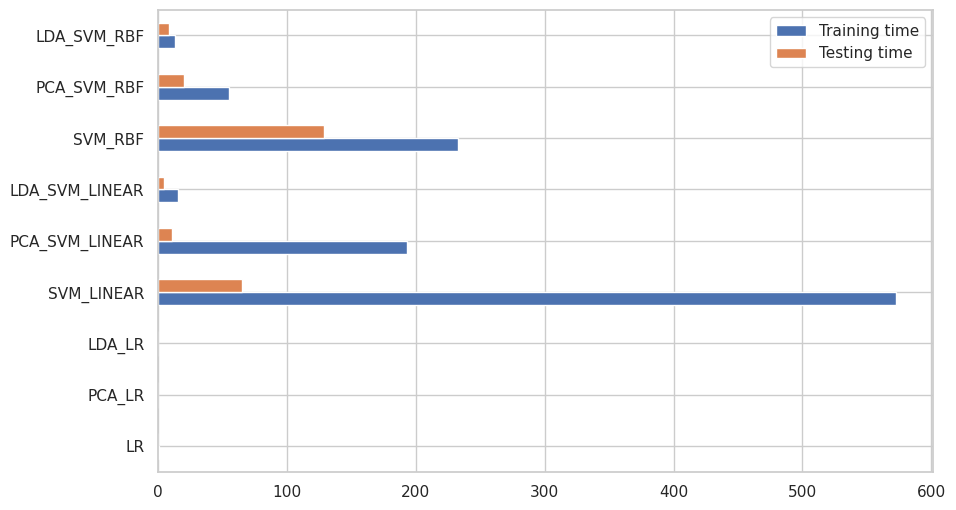

In [37]:
model_evaluation_time = model_evaluation[['Training time', 'Testing time']]
model_evaluation_time.plot(kind='barh', figsize=(10, 6))

__Linear Logistic:__
- The confusion matrix of PCA data and LDA data looks like the original one. `Class 6` is still the most confused class.
- Comparing accuracy, there is a slight error between them. The accuracy of Linear Regression using PCA is lower than the original one, as it loses about 10% of information. However, the LDA model has a higher accuracy.
- The longest computation time belongs to the original model, while the other times are really small.

__SVM (Linear):__
- We can see that in reduced-dimensional data, the Linear kernel performs better when reduced by PCA, while with LDA, the performance has slightly decreased.
- The computation time after dimensionality reduction has changed significantly, especially when reduced by LDA, where the computation time has reduced considerably (about __15s__ compared to nearly __600s__ when not reduced).

$\implies$ Dimensionality reduction yields results comparable to full data with significantly reduced computation time. PCA can be considered a reasonable dimensionality reduction technique as it improves performance while also speeding up computation time.

__SVM (RBF):__
- In reduced-dimensional data with PCA, we have performance nearly equivalent to when no dimensionality reduction is applied, while with LDA, the performance has decreased significantly.
- However, with the reduced-dimensional dataset, SVM with the RBF kernel computes much faster (similar to the Linear kernel).

$\implies$ PCA remains a suitable dimensionality reduction technique for SVM with the RBF kernel, providing us with sufficiently superior performance compared to the RBF kernel along with reasonable computation time (__~0.89__ accuracy with a total computation time of __75s__).

### Pros and cons of each model

#### Logistic Regression

#### SVM using Linear kernel
According to the experimental results, we find that SVM with the Linear kernel does not have many __pros__ compared to the other two models. However, it is the only model that improves performance when reducing the dimensionality of the data (using PCA).

__Cons:__
- Highest computation time among the three models
- Tends to overfit

#### SVM using RBF kernel
__Pros:__
- The model with the best performance on both full and reduced-dimensional data
- When combined with PCA, it can create a model that is both powerful and has reasonable computation time

__Cons:__
- Computation time is still long compared to Logistic Regression, but we can still consider this a reasonable trade-off for higher performance.

## Thank you for viewing our lab
